## Module 6, Assignment 1: Deep Neural Networks in Keras

Welcome to **Module 6, Assignment 1: Deep Neural Networks in Keras**! In this assignment, we will apply what we learned in this module and explore how to create, train, and modify a deep neural network using Keras. All questions in this assignment should be answered in the MITLearn environment. For most of the questions, you should use the code and outputs in this notebook to answer these questions.

This assignment is split into five parts, and the goals of this assignment in each part are as follows.

#### Part 1: Load and standardize the dataset
* Load the dataset
* Standardize the dataset

#### Part 2: Single hidden layer
* Define a Keras model with a single hidden layer
* Train the Keras model and plot loss curves
* Evaluate the model


#### Part 3: Two hidden layers
* Modify the Keras model from Part 2 by adding an additional hidden layer
* Train the modified Keras model and plot loss curves
* Evaluate the modified model

#### Part 4: Skip connection model
* Modify the Keras model from Part 2 so that the layers are connected in new ways (to be described later)
* Train the modified Keras model and plot loss curves
* Evaluate the modified model

#### Part 5: Hyperparameter tuning (optional)
* Use Keras Tuner to optimize across the number of layers and number of units in each layer

Let's start with importing the packages we need for this notebook.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Part 1: Load and standardize dataset

Before we get started with our neural network, we'll begin with loading our dataset. We will work with the California Housing dataset ([source](https://keras.io/api/datasets/california_housing/)), which is derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

This is a regression dataset with 8 features. The target variable is the median house value in the census block group, in dollars.

The 8 input features are the following:

* MedInc: median income in block group
* HouseAge: median house age in block group
* AveRooms: average number of rooms per household
* AveBedrms: average number of bedrooms per household
* Population: block group population
* AveOccup: average number of household members
* Latitude: block group latitude
* Longitude: block group longitude


The 20,640 rows of data have been split into train and validation sets and stored in numpy arrays.
* `x_train`, `x_val`: numpy arrays containing the training and validation X matrices, respectively.

* `y_train`, `y_val`: numpy arrays containing the values of the dependent variable for the training and validation sets respectively. These are numbers typically between 25000 and 500000 and represent home prices in dollars.

The code below loads the housing dataset from the library `datasets` from `keras`. This library, `datasets`, contains a few toy datasets that that are already vectorized in a nice format for our use. We will use the `california_housing` dataset.

Observe that when we load the data, we load a training set and a test set, and each of these consists of the features (`x_train`, `x_test`) and the target regression values (`y_train`, `y_test`). In the code below, (`x_train`, `y_train`) are the respective features and target regression values for the training dataset, and similarly, (`x_test`, `y_test`) are the respective features and target regression values for the test dataset.

So that we can see what the dataset looks like, we print the `x_train` dataset and also examine its shape (dimensions).

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.california_housing.load_data(
    version="large", path="california_housing.npz", test_split=0.2, seed=113
)

In [ ]:
print(x_train)

[[-118.27     34.09     52.     ... 1048.      491.        3.7847]
 [-118.36     33.96     21.     ... 1286.      557.        2.7284]
 [-122.39     37.76     52.     ...  712.      398.        3.9722]
 ...
 [-122.34     37.57     52.     ...  876.      359.        8.2598]
 [-122.18     37.89     18.     ... 1634.      734.        8.1489]
 [-118.43     34.2      29.     ... 1942.      679.        3.1118]]


In [ ]:
print(x_train.shape)

(16512, 8)


Now that we have loaded our housing dataset, we need to prepare the data for ingestion by the models we will create. The dataset is already generally prepared for us by the `datasets` library, but notice that some columns (features) seem quite large in scale and others are small. For example, it makes sense that the `Population` feature is quite large, especially relative to the `AveRooms` feature. For the purpose of training deep neural networks, we need to standardize the data. Recall that standardizing features means ensuring all features have zero mean and a standard deviation of 1, ensuring that all features are on the same or similar scale. We can standardize the value $x$ of a feature by subtracting the feature's mean $\mu$ and dividing by the feature's standard devation $\sigma$:
$$\bar{x} = \frac{x-\mu}{\sigma}.$$

Note that we use the training set's mean and standard deviation to standardize both the training and test set features, since the test set is supposed to be "unseen" data. Therefore, we should not and cannot compute its mean and standard deviation.

In [ ]:
# Standardize the data
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# AFTER standardization
# for x_train, mean and std (per feature) should be exactly 0 and 1,
# respectively, whereas for x_test, mean and std should be close to 0 and 1
# but not exactly

print(f"x_train mean: \n\t{x_train.mean(axis=0).round(2)}, \nx_train std: \n\t{x_train.std(axis=0).round(2)}")
print(f"x_test mean: \n\t{x_test.mean(axis=0).round(2)}, \nx_test std: \n\t{x_test.std(axis=0).round(2)}")

x_train mean: 
	[ 0. -0.  0. -0.  0. -0. -0.  0.], 
x_train std: 
	[1. 1. 1. 1. 1. 1. 1. 1.]
x_test mean: 
	[-0.02  0.02 -0.01 -0.02 -0.02 -0.03 -0.02  0.  ], 
x_test std: 
	[1.01 1.01 1.   0.93 0.94 0.89 0.93 1.01]


# Part 2: Single hidden layer

Now that we've standardized the data, we will create our first deep neural network! We will do so by defining a Keras model with a single hidden layer of 16 neurons, which is done in the code below.

In particular, the code block below does the following. The first line creates the model’s input “placeholder." `shape=(x_train.shape[1],)` means each sample is a 1D feature vector with `n_features = x_train.shape[1]` (e.g. the number of features is the same as the number of features in the training dataset). At this point, the tensor shape is `(None, n_features)` where `None` is the batch size.

The second line adds a fully connected (Dense) hidden layer with 16 neurons and ReLU activation. The parameter count here is `n_features * num_weights + num_biases = n_features * 16 + 16` (where there are 16 weights and 16 biases in this layer). The Output tensor shape of this layer is (None, 16).

The third line adds the output layer with 1 neuron and no activation (i.e., linear output). The parameter count here: 16 * 1 + 1 = 17. The output tensor shape of this layer is `(None, 1)`. Note that this linear output is typical for regression; for binary classification you’d usually use `activation='sigmoid'` here.

The final line wraps the defined graph into a Keras Model object you can compile/train/evaluate. We also name the model "model_part1", which is handy when you print summaries or use multiple submodels.

> **Useful information:** Note that in general, the number of trainable parameters in a layer can be computed with the following formula:
$$(\text{incoming units to this layer}\times \text{units in this layer}) + \text{units in this layer},$$
where if the layer is the first layer in the model, then the $\text{incoming units to this layer} = \text{number of input features}$.

In [ ]:
# define a keras model with a single hidden layer of 16 neurons
inputs = keras.Input(shape=(x_train.shape[1],))
x = keras.layers.Dense(16, activation='relu')(inputs)
outputs = keras.layers.Dense(1)(x)

model_part1 = keras.Model(inputs=inputs, outputs=outputs, name='model_part1')

Then, we use the `model.compile` function from Keras to set `adam` as the optimizer and `mse` (mean-squared error) as the loss function:

In [ ]:
# use model.compile with mse loss
model_part1.compile(optimizer='adam', loss='mse')

Next, we train our single-layer Keras model for 100 epochs using the `model.fit` function from Keras; we also specify that we will set aside 20% of the training set for validation purposes during training and use a batch size of 32. Note that `verbose=1` means that as te model is training, the full output will be printed for you to see (if you set `verbose=0`, then the output would not be as detailed or long).

In [ ]:
# train the keras model using model.fit, setting validation_split=0.2
history_part1 = model_part1.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 57064026112.0000 - val_loss: 56708866048.0000
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 55699382272.0000 - val_loss: 56698118144.0000
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 56968257536.0000 - val_loss: 56679256064.0000
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56156803072.0000 - val_loss: 56653279232.0000
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55719337984.0000 - val_loss: 56620560384.0000
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 56162652160.0000 - val_loss: 56582348800.0000
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56006291456.0000 - val_loss: 56539308032.0000
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55605784576.0000 - val_loss: 56491761664.0000
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55966420992.0000 - val_loss: 56439775232.0000
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━

Congratulations! We've trained our first deep neural network. Let's plot the loss curves, which are the training and validation loss as the epochs progres, to see how our training turned out.

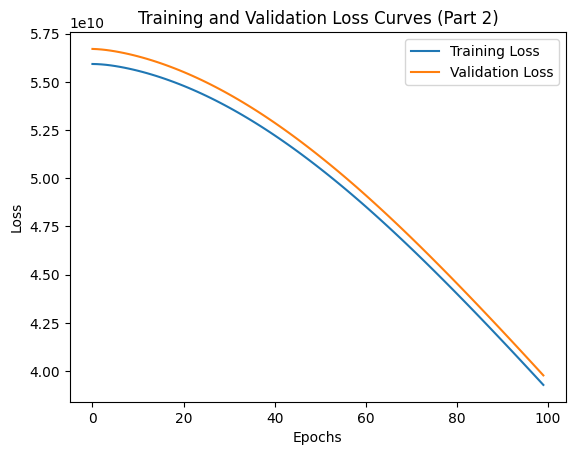

In [ ]:
# plot the loss curves
plt.plot(history_part1.history['loss'], label='Training Loss')
plt.plot(history_part1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves (Part 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Finally, let's evaluate our first deep neural network on unseen data by calculating the MSE (mean-squared error) on the test set. We use the `.evaluate` function from Keras to do so, which automatically calculates the MSE, since we compiled the model earlier with `mse` as the loss function.

In [ ]:
# calculate the MSE on the test set
mse_part1 = model_part1.evaluate(x_test, y_test)
print(f'MSE on Test Set (Part 2): {mse_part1}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39788781568.0000
MSE on Test Set (Part 2): 39278600192.0


# Part 3: Two hidden layers

We've made a model with one hidden layer! Let's now make a new model with two hidden layers. The code below creates the new model.


In particular, the code block below does the following. The first line is the same as before and creates the model’s input “placeholder." `shape=(x_train.shape[1],)` means each sample is a 1D feature vector with `n_features = x_train.shape[1]` (e.g. the number of features is the same as the number of features in the training dataset). At this point, the tensor shape is `(None, n_features)` where `None` is the batch size. Note that this is the same as the previous code because the inputs to the model are still `x_train`, like before.

The second line is also the same as before and adds a fully connected (Dense) hidden layer with 16 neurons and ReLU activation. The parameter count here is `n_features * num_weights + num_biases = n_features * 16 + 16` (where the number of biases is 16 and the number of biases is 16 in this layer). The Output tensor shape of this layer is (None, 16). Note that this is the same as before because our first layer in our new model is the same as the first (and only) layer in the previous model.

The third line adds our second Dense hidden layer, again with 16 neurons and ReLU activation function. Because the previous layer produces a vector of length 16, the input dimension to this second layer is 16. Our second Dense layer has 16 neurons and therefore 16 outputs, and it learns a weight for every connection from each of these 16 inputs to each of the 16 outputs. This means that there are $16\times16$ weights in this second layer. Each of the 16 neurons in the second layer also has its own bias term, so there are 16 biases. In total, the number of parameters in this second hidden layer is `16*16 + 16 = 272`, and the output shape is `(None, 16)`. We can also compute the 272 trainable parameters using the parameter formula from above.

The fourth line adds the output layer with 1 neuron and no activation (e.g., linear output). The parameter count here: 16 * 1 + 1 = 17. The output tensor shape of this layer is `(None, 1)`. Note that this linear output is typical for regression; for binary classification you’d usually use `activation='sigmoid'` here.

The final line wraps the defined graph into a Keras Model object you can compile/train/evaluate. We also name the model "model_part2", which is handy when you print summaries or use multiple submodels.

In [ ]:
# define a keras model with two hidden layers of 16 neurons each
inputs = keras.Input(shape=(x_train.shape[1],))
x = keras.layers.Dense(16, activation='relu')(inputs)
x = keras.layers.Dense(16, activation='relu')(x)  # Second hidden layer
outputs = keras.layers.Dense(1)(x)

model_part2 = keras.Model(inputs=inputs, outputs=outputs, name='model_part2')

Like before, we compile the model with the `adam` optimizer and use `mse` as our loss function. We also train our second model with the same number of epochs (100), validation split (0.2), and batch size (32). We also plot the loss curves for the training and validation loss functions as our second model trains, and we compute this second model's MSE on the test set.

In [ ]:
# use model.compile with mse loss
model_part2.compile(optimizer='adam', loss='mse')

In [ ]:
# train the keras model using model.fit, setting validation_split=0.2
history_part2 = model_part2.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 56046891008.0000 - val_loss: 56647110656.0000
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55922446336.0000 - val_loss: 56179916800.0000
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55152390144.0000 - val_loss: 55035744256.0000
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54162034688.0000 - val_loss: 53081530368.0000
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 51778621440.0000 - val_loss: 50292871168.0000
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 48807776256.0000 - val_loss: 46754279424.0000
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 45147803648.0000 - val_loss: 42640187392.0000
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 40899272704.0000 - val_loss: 38157893632.0000
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36475277312.0000 - val_loss: 33541556224.0000
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━

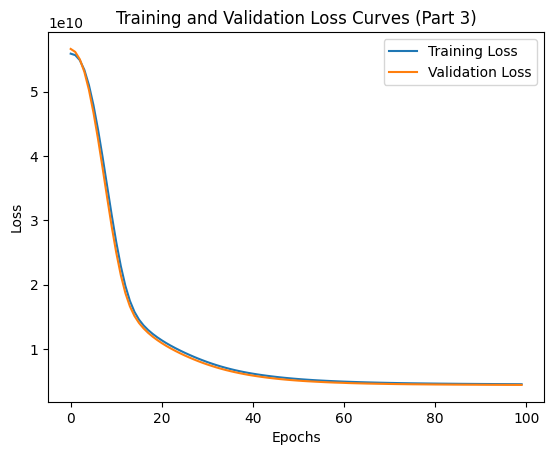

In [ ]:
# plot the loss curves
plt.plot(history_part2.history['loss'], label='Training Loss')
plt.plot(history_part2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves (Part 3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# calculate the MSE on the test set
mse_part2 = model_part2.evaluate(x_test, y_test)
print(f'MSE on Test Set (Part 3): {mse_part2}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4980265472.0000
MSE on Test Set (Part 3): 4710387712.0


# Part 4: Skip connection model

Congratulations on training a deeper neural network, with two layers instead of just one! Now, we will try to build an even more complex model. This time, we will create another two-layer neural network, but the input layer will also be connected directly to the output layer, e.g. the output layer is connected to the input layer and the hidden layer. We call this kind of model a "skip connection model", since the input layer skips a connection and connects directly to the output layer.

For this part, we will need a few additional libraries, which we import below.

In [ ]:
from keras.models import Model
from keras.layers import Input, Concatenate

In the below code, we create our skip connection model.

> **Additional information (optional)**:
> The first line creates an input layer for the model using `keras.Input`, where the shape argument specifies the number of features from the training data (`x_train.shape[1]`). This layer will feed data into both the hidden layer and directly into the output layer.
>
> The second line defines a hidden layer using `keras.layers.Dense` with 16 neurons and a line activation function like before. It takes its input from the previously defined input layer and will send its output to the output layer.
>
> The third line is a concatenation operation performed using `keras.layers.Concatenate()`. This combines the outputs from the input layer and the hidden layer into a single tensor, effectively creating the desired skip connection from the input to the output.
>
> The fourth line defines the output layer as a dense layer with a single neuron (`Dense(1)`), which takes the concatenated input and hidden layer outputs as its input like before. This will produce the final prediction of the model.
>
> Finally, the last line creates the `Keras` model object named `model_part3` by specifying the input layer (`inputs`) and the output layer (`outputs)`. This model incorporates both the direct input-to-output connection and the hidden layer, enabling richer learning and skip connection benefits.

In [ ]:
# input layer (this will go into both the hidden layer and the output layer)
inputs = keras.Input(shape=(x_train.shape[1],))
# hidden layer (inputs from input layer, outputs to output layer)
hidden = keras.layers.Dense(16, activation='relu')(inputs)

# concatenate (combine) input + hidden layer to send to output (skip connection)
concat = keras.layers.Concatenate()([inputs, hidden])
# output layer
outputs = keras.layers.Dense(1)(concat)

# create model
model_part3 = keras.Model(inputs=inputs, outputs=outputs, name='model_part3')

Like before, we compile the model with the `adam` optimizer and use `mse` as our loss function. We also train our third model with the same number of epochs (100), validation split (0.2), and batch size (32). We also plot the loss curves for the training and validation loss functions as our third model trains, and we compute this third model's MSE on the test set.

In [ ]:
# use model.compile with mse loss
model_part3.compile(optimizer='adam', loss='mse')

In [ ]:
# train the keras model using model.fit, setting validation_split=0.2
history_part3 = model_part3.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 55923781632.0000 - val_loss: 56707325952.0000
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 56127442944.0000 - val_loss: 56693506048.0000
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55301656576.0000 - val_loss: 56670883840.0000
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55702945792.0000 - val_loss: 56639422464.0000
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55000268800.0000 - val_loss: 56601124864.0000
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 54954020864.0000 - val_loss: 56556695552.0000
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56570896384.0000 - val_loss: 56506802176.0000
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 55960301568.0000 - val_loss: 56451735552.0000
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 56393109504.0000 - val_loss: 56391389184.0000
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━

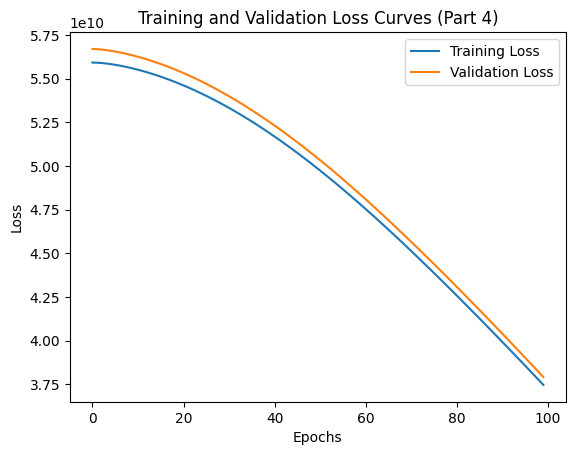

In [ ]:
# plot the loss curves
plt.plot(history_part3.history['loss'], label='Training Loss')
plt.plot(history_part3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves (Part 4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# calculate the MSE on the test set
mse_part3 = model_part3.evaluate(x_test, y_test)
print(f'MSE on Test Set (Part 4): {mse_part3}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37949763584.0000
MSE on Test Set (Part 4): 37417168896.0


# Part 5: Hyperparameter tuning (optional)

Congratulations on training a skip connection model! Let's now explore **hyperparameter tuning**, which is the process of selecting the best set of hyperparameters — the configuration settings that control how a machine learning model is trained but are not learned from the data itself — to optimize the model’s performance.

These hyperparameters can include things like the learning rate, number of layers, number of neurons per layer, regularization strength, batch size, and number of training epochs.

The goal of hyperparameter tuning is to systematically search through possible combinations (using methods such as [grid search](https://www.dremio.com/wiki/grid-search/), [random search](https://www.scaler.com/topics/machine-learning/random-search-in-machine-learning/), or [Bayesian optimization](https://wandb.ai/wandb_fc/articles/reports/What-Is-Bayesian-Hyperparameter-Optimization-With-Tutorial---Vmlldzo1NDQyNzcw)) to find the configuration that yields the best results on a validation dataset, improving the model’s generalization to unseen data.

We first need to install and import some additional packages for hyperparameter tuning, which we do in the following code cells.

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.0 MB/s eta 0:00:00


In [ ]:
# required libraries for hyperparameter tuning
import keras_tuner as kt

To tune hyperparameters using the library `keras_tuner`, we need a model building function. The code below defines a function called `build_model` that will be used with Keras Tuner to perform hyperparameter tuning.

The function takes `hp` as an argument, which is an object provided by Keras Tuner for specifying and sampling hyperparameters. Inside the function, the input layer is created with a shape of (8,), meaning the model expects eight features as input. Recall that we expect eight features because our housing dataset has eight features. The variable `x` is set to refer to these inputs so layers can be added to it.

Next, the code specifies a hyperparameter called `num_layers` that determines how many hidden layers the network will have. This value can be 1, 2, or 3, and is chosen during tuning.

A loop then runs once for each hidden layer. In each iteration, another hyperparameter is defined, `units_i`, which can take on the value 4 or 8. This determines how many neurons are in that particular hidden layer. A dense layer with that number of units and the ReLU activation function is added to the model, using the current `x` as input and replacing `x` with the new layer’s output.

After all the hidden layers are added, an output layer with a single neuron and no activation function is created. This layer connects to the most recent hidden layer output.

The final model is built by connecting the inputs to the outputs and naming it `tuned_model`. The model is compiled with the `adam` optimizer and mean squared error (MSE) loss function, making it suitable for regression tasks. Finally, the compiled model is returned so Keras Tuner can evaluate it with different hyperparameter settings.

In [ ]:
# keras tuner requires a model building function
def build_model(hp):
    # input layer
    inputs = keras.Input(shape=(8,))
    x = inputs
    # number of layers (1, 2, or 3)
    n_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)

    # layer units (4 or 8)
    for i in range(n_layers):
        units = hp.Choice(f'units_{i}', values=[4, 8])
        x = keras.layers.Dense(units, activation='relu')(x)

    # output
    outputs = keras.layers.Dense(1)(x)

    # final model
    model = keras.Model(inputs=inputs, outputs=outputs, name='tuned_model')
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    return model

Now that we have our `build_model` function, we can create the actual tuner that will tune our hyperparameters. The code below does exactly this.

This code creates a Keras Tuner `GridSearch` object to explore different hyperparameter combinations for building and training models. To learn more about grid search as a method, please refer to the link provided above, in the introduction to Part 4.

The GridSearch is initialized with the `build_model` function, which defines how the model is constructed based on given hyperparameters. The `objective='val_loss'` argument tells the tuner to choose the model configuration that minimizes the validation loss. The `max_trials=6` parameter specifies that only six different hyperparameter combinations will be tested. The `directory='hp_tuning'` argument indicates where the tuner should store its results, and `project_name='housing_regression'` sets a subdirectory for this specific tuning run. Finally, `tuner.search_space_summary()` is called to print a description of the hyperparameters and their possible values, so you can see what configurations the tuner will evaluate.

In [ ]:
# create the actual tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=6,  # 6 combinations total
    directory='hp_tuning',
    project_name='housing_regression'
)

# print search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8], 'ordered': True}


We can now actually run the search, which will tune for the best hyperparameters.

The code below runs this hyperparameter search using the tuner that was created above. The `tuner.search()` function takes the training features `x_train` and corresponding target values `y_train` as input. It will train each model configuration for up to 100 epochs, as specified by the `epochs=100` argument like previously. The `validation_split=0.2` parameter means that 20% of the training data will be set aside for validation during tuning (again like before), so the tuner can evaluate how well each model generalizes. The `verbose=1` setting ensures that progress messages and results are printed to the console during the search, making it easy to track the tuning process in real time.

In [ ]:
# run the search
tuner.search(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.2,
    verbose=1
)

Trial 6 Complete [00h 02m 16s]
val_loss: 4824116736.0

Best val_loss So Far: 4718274560.0
Total elapsed time: 00h 13m 39s


After our search is complete, we need to extract the best model and hyperparameters that resulted from our search.

The code below retrieves these best-performing hyperparameters and model from the Keras Tuner search, then prints the results in a readable format.

First, `best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]` calls the tuner’s `get_best_hyperparameters` method to return the top hyperparameter configurations from the tuning process, keeping only the single best one (via `num_trials=1`) and selecting the first (and only) item in that list with `[0]`. Next, `best_model = tuner.get_best_models()[0]` retrieves the best-performing trained model from the tuning process in a similar manner and stores it in `best_model`.

The code then prints the optimal hyperparameters. It first the prints the number of layers using `best_hps.get('num_layers')`. It then loops through each of those layers, printing the number of units for each layer with `best_hps.get(f'units_{i}')`.

Finally, it calls `best_model.summary()`, which displays a detailed layer-by-layer summary of the chosen model, including layer types, output shapes, and parameter counts.

In [ ]:
# get best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models()[0]

# print
print("\nOptimal Hyperparameters:")
print(f"Number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Units in layer {i+1}: {best_hps.get(f'units_{i}')}")

best_model.summary()


Optimal Hyperparameters:
Number of layers: 2
Units in layer 1: 8
Units in layer 2: 4


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "tuned_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113 (452.00 B)

 Trainable params: 113 (452.00 B)

 Non-trainable params: 0 (0.00 B)

Just because we have found the optimal hyperparameter configuration does not mean the best model has been trained fully. We need to retrain the best model found during hyperparameter tuning above. The code below does this retraining and then plots the trained best model's training history like we've done previously.

In particular, the first code block calls the model’s `fit` method to train it again on the training data `x_train` and `y_train` for 100 epochs. It reserves 20% of the training data for validation (`controlled by validation_split=0.2`). The `verbose=1` setting prints detailed progress for each epoch. The returned history object stores the recorded training and validation metrics for each epoch.



Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4867992064.0000 - val_loss: 4709270016.0000
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4779494912.0000 - val_loss: 4702705152.0000
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4612191232.0000 - val_loss: 4695812096.0000
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4905899520.0000 - val_loss: 4688742912.0000
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4906992640.0000 - val_loss: 4681907200.0000
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4871689216.0000 - val_loss: 4676549120.0000
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4737323520.0000 - val_loss: 4670597120.0000
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4631536640.0000 - val_loss: 4664111616.0000
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4997554176.0000 - val_loss: 4660662784.0000
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

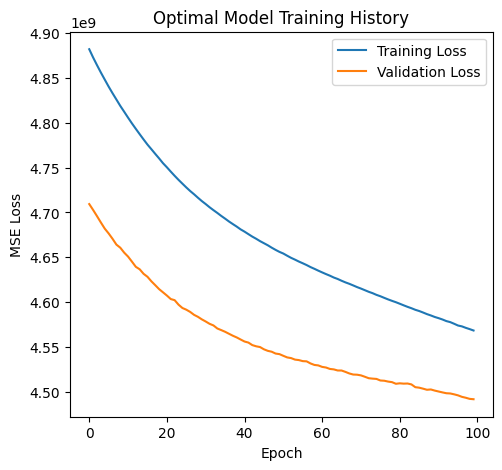

In [ ]:
# retrain best model to get history
history = best_model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.2,
    verbose=1
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Optimal Model Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

Now that we have our trained best model based on hyperparameter tuning, we can evaluate it using its test set MSE and also compare this MSE with previous models. This code below evaluates the tuned model’s performance, compares it to earlier models, and visualizes the results.


The visualization is done in the second to last code block, which visualize model performance by creating a scatter plot of predicted versus actual values. We first creates a figure, predicts values for the test set with predict, and plots them as semi-transparent points (semi-transparent due to the argument `alpha=0.5`). The red dashed line (`'r--'`) represents perfect predictions where actual equals predicted. The plot title shows the model’s MSE, and the axes are labeled as “Actual Price” and “Predicted Price.”

The last code block calculates and displays R-squared by importing the `r2_score` metric from `scikit-learn`, computing the coefficient of determination between actual and predicted values, and printing it with three decimal places. This R-squared value indicates how well the model explains the variance in the target data.



Best Model Test MSE: 4,756,561,408.00

Comparison with Previous Models:
Part 2 (Single Hidden Layer) MSE: 39,278,600,192.00
Part 3 (Two Hidden Layers) MSE: 4,710,387,712.00
Part 4 (Skip Connection) MSE: 37,417,168,896.00
Optimal Tuned Model MSE: 4,756,561,408.00


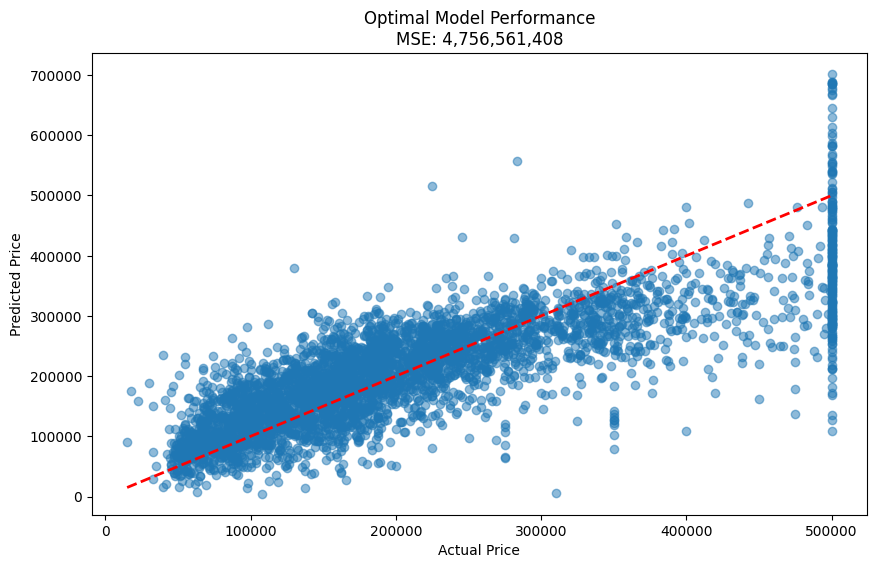


Optimal Model R-squared: 0.642


In [ ]:
# evaluate best model
best_mse = best_model.evaluate(x_test, y_test, verbose=0)
print(f"\nBest Model Test MSE: {best_mse:,.2f}")

# compare with previous models
print("\nComparison with Previous Models:")
print(f"Part 2 (Single Hidden Layer) MSE: {mse_part1:,.2f}")
print(f"Part 3 (Two Hidden Layers) MSE: {mse_part2:,.2f}")
print(f"Part 4 (Skip Connection) MSE: {mse_part3:,.2f}")
print(f"Optimal Tuned Model MSE: {best_mse:,.2f}")

# visualize best model performance
# 1. predictions vs actual
plt.figure(figsize=(10, 6))
y_pred = best_model.predict(x_test, verbose=0)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Optimal Model Performance\nMSE: {best_mse:,.0f}')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

# 2. calculate and display R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"\nOptimal Model R-squared: {r2:.3f}")


Finally, we can more concisely summarize and compare the performance of different models using various metrics. The code below does just that.

This code first creates a dictionary called `results` to store details about four different models: the single hidden layer model, the two hidden layers model, the skip connection model, and the optimal tuned model. For each model, the dictionary stores three things: the trained model object, the training history, and the mean squared error (MSE) on the test set.

Next, the code prints the raw MSE comparison by looping through the dictionary and printing the test MSE for each model, formatted to two decimal places. It then calculates the normalized MSE, which rescales each model’s MSE by dividing it by the largest MSE among all models. This gives a value between 0 and 1, where lower values indicate better performance, and prints these normalized scores.

Finally, the code computes the R-squared score for each model. It imports the `r2_score` function from `sklearn.metrics`, then loops through each model, uses the model to predict the outputs for the test set, and calculates the R-squared score by comparing predictions to actual test labels. It prints each R-squared value to three decimal places.

Overall, this script summarizes and compares the performance of different models using raw error, scaled error, and goodness-of-fit.

In [ ]:
# store all results in a dictionary for easier comparison
results = {
    'Single Hidden Layer': {
        'model': model_part1,
        'history': history_part1,
        'test_mse': mse_part1
    },
    'Two Hidden Layers': {
        'model': model_part2,
        'history': history_part2,
        'test_mse': mse_part2
    },
    'Skip Connection': {
        'model': model_part3,
        'history': history_part3,
        'test_mse': mse_part3
    },
    'Optimal Tuned Model': {
        'model': best_model,
        'history': history,  # from the retrained best model
        'test_mse': best_mse
    }
}


# 1. raw MSE Comparison
print("Raw MSE Comparison:")
for name, result in results.items():
    print(f"{name}: {result['test_mse']:,.2f}")

# 2. normalized MSE (relative to worst performing model)
max_mse = max(result['test_mse'] for result in results.values())
print("\nNormalized MSE (0-1 scale, lower is better):")
for name, result in results.items():
    normalized_mse = result['test_mse'] / max_mse
    print(f"{name}: {normalized_mse:.3f}")


# 3. calculate R-squared for each model
from sklearn.metrics import r2_score

print("\nR-squared scores:")
for name, result in results.items():
    y_pred = result['model'].predict(x_test, verbose=0)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: {r2:.3f}")


Raw MSE Comparison:
Single Hidden Layer: 39,278,600,192.00
Two Hidden Layers: 4,710,387,712.00
Skip Connection: 37,417,168,896.00
Optimal Tuned Model: 4,756,561,408.00

Normalized MSE (0-1 scale, lower is better):
Single Hidden Layer: 1.000
Two Hidden Layers: 0.120
Skip Connection: 0.953
Optimal Tuned Model: 0.121

R-squared scores:
Single Hidden Layer: -1.955
Two Hidden Layers: 0.646
Skip Connection: -1.815
Optimal Tuned Model: 0.642


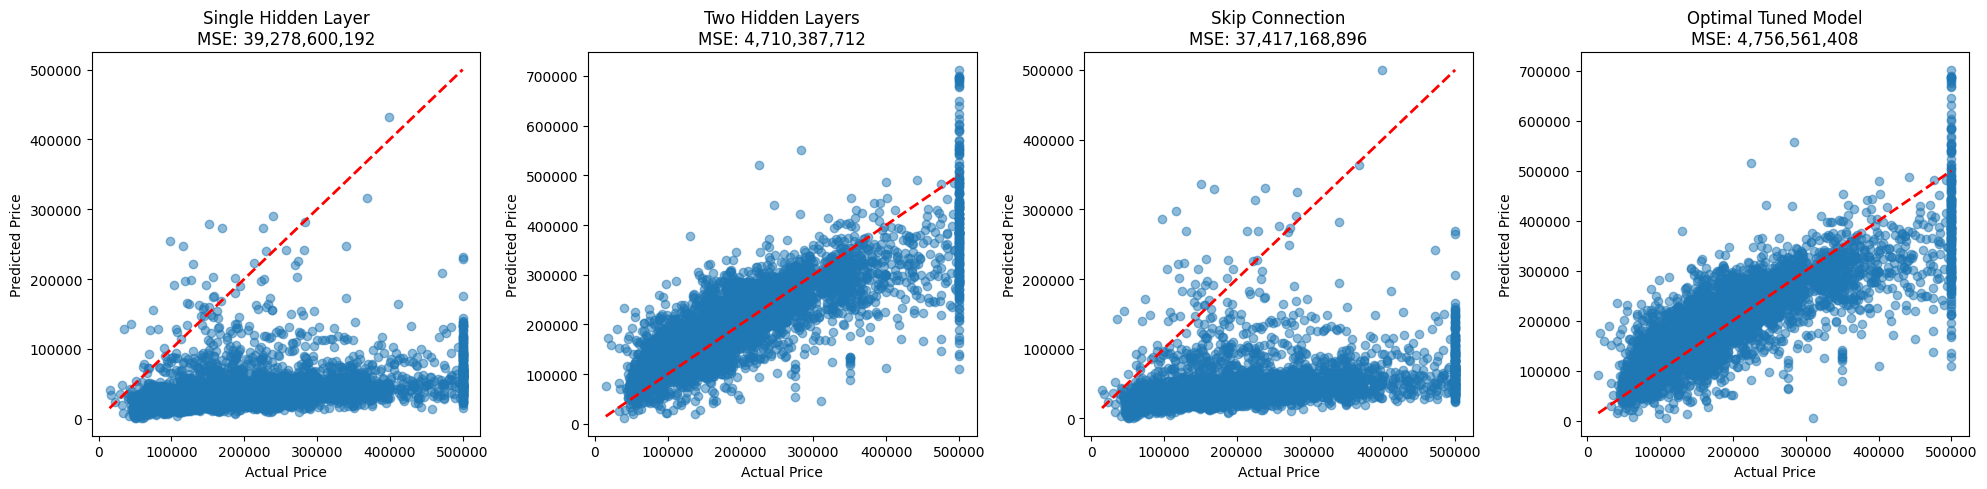

In [ ]:
# 4. plot predictions vs actual values for test set
plt.figure(figsize=(20, 5))  # Made wider to accommodate 4 plots
for idx, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 4, idx)
    # predictions
    y_pred = result['model'].predict(x_test, verbose=0)
    # scatter of predicted vs actual
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'{name}\nMSE: {result["test_mse"]:,.0f}')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
plt.tight_layout()
plt.show()
